In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from OIP21_lib_ImageProcessing_V6 import *
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
plt.rcParams['figure.figsize'] = [12, 10]
#%matplotlib notebook

In [2]:
def mean_class_variance(hist, thresh):
    wf = 0.0
    uf = 0.0
    ub = 0.0
    wb = 0.0
    total = np.sum(hist)
    # print(total)
    if len(hist) > 256:
        raise IndexError("object too large, recheck input")
    for i in range(len(hist)):
        if i < thresh:
            wb += hist[i]
            ub = ub + (i * hist[i])
        elif i >= thresh:
            wf += hist[i]
            uf = uf + (i * hist[i])
    if wb==0:
        ub=0
    else:
        ub = ub / wb
    if wf == 0:
        uf=0
    else:
        uf = uf / wf
    wb = wb / total
    wf = wf / total




    #print(thresh,wb,wf,uf,ub,total)
    variance = float(wb * wf * ((ub - uf) ** 2))
    return (variance, thresh)

def auto_thresh(img, mode="Thresholding"):
    hst = hist256(img)
    variance_list = []
    for thresh in range(len(hst)):
        if thresh > 1:
            variance_list.append(mean_class_variance(hst, thresh))
    # print(variance_list)
    # print("MAX tuple: ", max(variance_list))
    var, thresh = max(variance_list)
    #print("MAX tuple: ", thresh)
    if mode == "Thresholding":
        return threshold(img, thresh)
    elif mode == "UpperSave":
        img[img <= thresh] = 0
        return img
    elif mode == "LowerSave":
        img[img >= thresh] = 255
        return img

In [3]:
def FloodFillLabeling_modified(imgBIN):

    label = 2
    # collect the non-zero / foreground elements: 
    nzi = np.nonzero(imgBIN)
    # make copy: 
    IMG = deepcopy(imgBIN)

    zones = []
    # Flood fill loop: 
    #for cnt, u in enumerate(FGu):
    for i in np.transpose(nzi):
        IMG , zone = FloodFill_BF_modified(IMG, i[0] , i[1], label)
        if (not zone[0]==0) and (not zone[1]==IMG.shape[0]) and (not zone[2]==0) and (not zone[3]==IMG.shape[1]):
            zones.append(zone)
            label = label + 1
    return IMG ,zones

#insert image, (u,v) (start pixel), label nr
def FloodFill_BF_modified(IMG, u, v, label):
    '''
    Breadth-First Version (we treat lists as queues)
    '''
    xmax=0
    xmin=IMG.shape[0]
    ymax=0
    ymin=IMG.shape[1]
    S = []
    S.append([u,v])
    while S:  # While S is not empty...
        xy = S[0]
        x = xy[0]
        y = xy[1]
        S.pop(0)
        if x <= IMG.shape[0] and y <= IMG.shape[1] and  IMG[x,y] == 1:
            if xmax<x:
                xmax=x
            elif xmin>x:
                xmin=x
            if ymax<y:
                ymax=y
            elif ymin>y:
                ymin=y
            IMG[x,y] = label
            if x+1<IMG.shape[0]:
                S.append([x+1, y])
            if y+1<IMG.shape[1]:
                S.append([x, y+1])
            if y-1>=0:
                S.append([x,y-1])
            if x-1>=0:
                S.append([x-1,y])
    return IMG , [xmax,xmin,ymax,ymin]


Text(0.5, 1.0, 'Region label OIP')

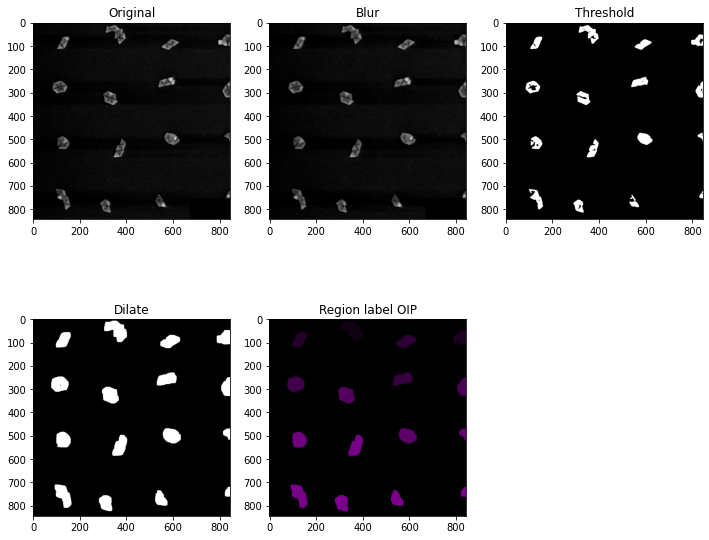

In [4]:
Number = 3
# Start loading in the 3 image types, 
# The first type is a Circle cluster image
# The second type is a Line/Rod cluster image
# The third type is a triangle cluster image
if Number == 1:
    img = cv2.imread('001_002.tif', cv2.IMREAD_GRAYSCALE)
elif Number == 2:
    img = cv2.imread('R001_001.tif', cv2.IMREAD_GRAYSCALE)
elif Number == 3:
    img = cv2.imread('T001.png', cv2.IMREAD_GRAYSCALE)

# Then we cut the gunk that is not needed from the image, this would be un-needed data
# or things that should not be in the image like half-clusters and other things that would
# screw with the data.

if Number == 1:
    img = img[0:870,:]
    img_org = img
elif Number == 2: 
    img = img[0:870,0:1000]
    #img = img[52:244,382:664]
    #img = img[0:870,0:679]
    #img = img[100:870,0:750]
    img_org = img
elif Number == 3:
    img[755:844,672:845] = 0
    img_org = img

#prepare for region labeling    
img = cv2.medianBlur(img, 7)
ret,thresh = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
kernel = np.ones((7,7), np.uint8)
threshDil = cv2.dilate(thresh, kernel, iterations=2)

#255 to 1 since floodfill is expecting that
threshDilBin = threshDil.copy()
threshDilBin[threshDilBin == 255] = 1
threshDilBin = threshDilBin.astype('uint16')

labelsOIP , zones = FloodFillLabeling_modified(threshDilBin)

plt.subplot(2,3,1)
plt.imshow(img_org,'gray',vmin=0,vmax=255)
plt.title("Original")
plt.subplot(2,3,2)
plt.imshow(img,'gray',vmin=0,vmax=255)
plt.title("Blur")
plt.subplot(2,3,3)
plt.imshow(thresh,'gray',vmin=0,vmax=255)
plt.title("Threshold")
plt.subplot(2,3,4)
plt.imshow(threshDil,'gray',vmin=0,vmax=255)
plt.title("Dilate")
plt.subplot(2,3,5)
plt.imshow(labelsOIP,cmap='nipy_spectral',vmin=0,vmax=255)
plt.title("Region label OIP")

In [5]:
height, width = np.shape(img_org)
clusterArray=[]

for i in zones:
    y2=i[0]
    y1=i[1]
    x2=i[2]
    x1=i[3]
    if(x1>0 and y1>0 and x2<width-1 and y2<height-1):
        clusterArray.append(img_org[y1:y2,x1:x2])


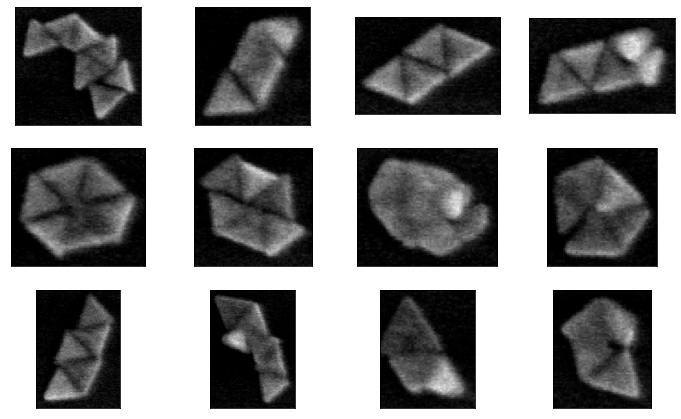

In [6]:
size = math.ceil(math.sqrt(len(clusterArray)))
count = 1

for i in clusterArray:
    plt.subplot(size,size,count)
    plt.imshow(i,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    count+=1

In [15]:
def find_particle(img, x,y,r, percentage=0.1): #set to 10% by default
    np.ceil(r)
    img_temp = img[int(y - r):int(y + r), int(x - r):int(x + r)]
    whitePixles = cv2.countNonZero(img_temp)
    if whitePixles >= (r * r * 4) * percentage:  # Calculate the area of a circle and then multiplies it by the % and then checks if it is bigger then the white in the area
        return True  # if the smallest white is bigger then area*% append it
    else:
        # print("thing ignored, size ", whitePixles)
        return False


def locwatershed(img_org, thresh2, modifier=1.9):
    zoom = False
    redux = False
    img = img_org.copy()
    l, b = np.shape(thresh2)
    if l < 50 and b < 50:
        zoom = True
        # print("zoom activated", l,b)
        img = cv2.resize(img, (0, 0), fx=1.2, fy=1.2)
        thresh2 = cv2.resize(thresh2, (0, 0), fx=4, fy=4)
    kernel = np.array(Mex5, np.uint8)  # np.ones((3, 3), np.uint8)
    temp = min_filter(thresh2, 3)
    # thresh2= auto_thresh(thresh2)
    temp = cv2.dilate(cv2.erode(temp, kernel, iterations=1), kernel, iterations=1)

    if cv2.countNonZero(temp) > 0.4 * cv2.countNonZero(thresh2) and not zoom:
        thresh2 = temp
        redux=True
        print(cv2.countNonZero(temp), 0.6 * cv2.countNonZero(thresh2))
    else:
        kernel =  np.ones((3, 3), np.uint8)
        thresh2=cv2.erode(thresh2, kernel, iterations=1)
    minareacircles = []
    avgr = []

    D = ndimage.distance_transform_edt(thresh2)
    localMax = peak_local_max(D, indices=False, min_distance=5,
                              labels=thresh2)
    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then apply the Watershed algorithm
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh2)

    # print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(thresh2.shape, dtype="uint8")
        mask[labels == label] = 255
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        # draw a circle enclosing the object
        ((x, y), r) = cv2.minEnclosingCircle(c)
        if(find_particle(thresh2,x,y,r,0.3)):
            minareacircles.append([x, y, r])
            avgr.append(r)
    try:
        # print(avgr)
        # print(np.mean(avgr)-2*np.std(avgr), "\n\n\n")
        # Removed = [i for i in minareacircles if i[2] < np.mean(avgr)-modifier*np.std(avgr)]
        # print("::: REmoved DAta:::", len(Removed))
        minareacircles = [i for i in minareacircles if i[2] >= np.mean(avgr)-modifier*np.std(avgr)]

        for l in minareacircles:
            x, y, z = l
            cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 1)
    except Exception as E:
        print("Error: ", E, len(np.unique(labels)))
#     cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
#     cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    # show the output image
    # print("Comaprison::",len(minareacircles),len(np.unique(labels))-1)
    if redux:
        print(minareacircles,cv2.countNonZero(temp) ,cv2.countNonZero(thresh2))
    return thresh2,labels ,img, len((minareacircles))


(71, 71)
8
(64, 76)


C:\Users\agnib\AppData\Local\Temp/ipykernel_8728/3537839430.py:38: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=5,


7
(66, 61)
6
(89, 63)
6
(99, 71)
10


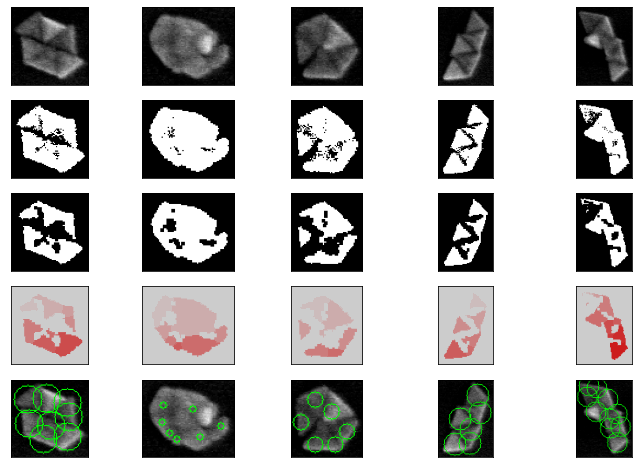

In [28]:
count = 1
#175
start = 5
plotX = 5
plotY = 6
# 

for i in clusterArray[start:start+5]:
    print(np.shape(i))
    img_thresh=auto_thresh(i)
    img_thresh2,labels, watershed_img, c=locwatershed(cv2.cvtColor(i, cv2.COLOR_GRAY2BGR), img_thresh)
    print(c)
    
    plt.subplot(plotY,plotX,count)
    plt.imshow(i,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5)
    plt.imshow(img_thresh,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*2)
    plt.imshow(img_thresh2,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*3)
    plt.imshow(labels,'nipy_spectral_r',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*4)
    plt.imshow(watershed_img,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    
    count+=1
#     plt.show()
    